# Basics of Mobile Robotics: Project - Part Global Nav


# Author : PB

In [100]:
import numpy as np
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from src import model,thymio

## GLOBAL NAVIGATION IMPLEMENTATION

I decided to develop and test my global navigation on this notebook before implementing it in the folder

In [101]:
# USE OF MPC

#	X    -----------------      u       ---------
#	---> | MPC Regulator |------------> | Plant |----------> Output
#	|    -----------------              ---------   |
#	|           ^                                   |
#	|           | (xs, us)                          |
#	|           |                                   |
#	|           |       ------------                |
#	|           --------| target   |<----------------
#	|                   | selector |<-- reference   |
#	|                   ------------                |
#	|                                               |
#	-------------------------------------------------

Initial parameters

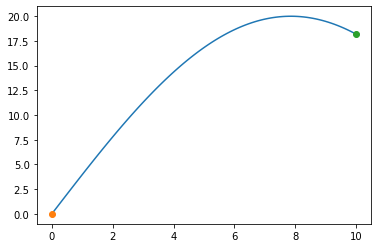

In [115]:
# initialization block
Tf = 10
min_velocity = 0
max_velocity = 1
min_deviation_phi = -1
max_deviation_phi = 1

tps = np.linspace(0, Tf, Tf)


#create the data point
xaxis = np.linspace(0.0, 10.0, num=100)
yaxis = 20*np.sin(xaxis/5)

Length = len(xaxis)
Sequence = []
for i in range(Length):
    p = model.Point(xaxis[i], yaxis[i])
    Sequence.append(p)
#Sequence = np.array(Sequence)

#plt.plot(tps, 3*np.sin(tps/3))
plt.plot(xaxis, yaxis)

x0 = [0., 0., 0.2]; u0 = [np.sqrt((tps[1]-tps[0])**2 + (np.sin(tps[1])-np.sin(tps[0]))**2), (tps[1]-tps[0])/Tf]
xf = [Sequence[-1].x, Sequence[-1].y, 0.]; uf = [10., 0.]

def lafonc(x):
    return 3*np.sin(x/3)

Q = np.array([[0.1, 0, 0],[0, 0.1, 0], [0, 0, 0.1]])          # don't turn too sharply
R = np.diag([1, 1])               # keep inputs small
P = np.diag([1000, 1000, 1000])   # get close to final point


plt.plot(x0[0], x0[1], marker="o")
plt.plot(xf[0], xf[1], marker="o")

Useful functions

In [103]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    #phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    
    # Saturate the steering input
    phi = np.clip(u[1], min_deviation_phi, max_deviation_phi)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi)        # thdot = v/l tan(phi)
    ])



def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

First iteration test

In [117]:
LengthHorizon = 3

traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
"""
def fun(x,u):
    index = min(range(len(Sequence)), key=lambda i: abs(Sequence[i].x-x[0]))
    return x[1]-Sequence[index].y
lb = -0.1
ub = 0.1
"""
#constraints = [{"type": "ineq", "fun": lambda x: x[0] - 3*np.sin(x[1]/3)+2},{"type": "ineq", "fun": lambda x: -x[0] + 3*np.sin(x[1]/3)+2}]
#constraints = [(scopt.NonlinearConstraint, fun, lb, ub), opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi]) ]
WidthTunnel = 0.5
# Sequence[min(range(len(Sequence)), key=lambda i: abs(Sequence[i].x-x[0]))].y-WidthTunnel
constraints = [opt.state_range_constraint(vehicle, [-np.inf, Sequence[min(range(len(Sequence)), key=lambda i: abs(Sequence[i].x-x[0]))].y-WidthTunnel, -np.inf], [np.inf, Sequence[min(range(len(Sequence)), key=lambda i: abs(Sequence[i].x-x[0]))].y+WidthTunnel, np.inf]), opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi])]
print(constraints)  

horizon = np.linspace(0, LengthHorizon, LengthHorizon, endpoint=True)
result = opt.solve_ocp(vehicle, horizon, x0, traj_cost, constraints, terminal_cost=term_cost, initial_guess=u0, log=False)

# Simulate the system dynamics (open loop)
resp = ct.input_output_response(
    vehicle, horizon, result.inputs, x0,
    t_eval=np.linspace(0, LengthHorizon, LengthHorizon))
t, y, u = resp.time, resp.outputs, resp.inputs

# Plot
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.plot(xaxis, yaxis, 'g')
plt.plot(y[0], y[1], 'o-')
plt.show()
print(y)

NameError: name 'x' is not defined

Optimization loop

step 0


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 75
* Constraint calls: 92
* System simulations: 145
* Final cost: 281399.28937450575
step 1


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(
c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(
c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 99
* Constraint calls: 117
* System simulations: 176
* Final cost: 215839.32431021077
step 2
Summary statistics:
* Cost function calls: 15
* Constraint calls: 25
* System simulations: 36
* Final cost: 163320.7004587305
step 3
Summary statistics:
* Cost function calls: 15
* Constraint calls: 25
* System simulations: 36
* Final cost: 121798.87159851394
step 4


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(
c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 74
* Constraint calls: 91
* System simulations: 144
* Final cost: 79669.65722992588
step 5
Summary statistics:
* Cost function calls: 53
* Constraint calls: 68
* System simulations: 109
* Final cost: 57890.01352610747
step 6


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(
c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 31
* Constraint calls: 42
* System simulations: 59
* Final cost: 30090.56686752206
step 7
Summary statistics:
* Cost function calls: 48
* Constraint calls: 61
* System simulations: 90
* Final cost: 15518.939710659244
step 8


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(
c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 69
* Constraint calls: 84
* System simulations: 125
* Final cost: 12619.789256908578
step 9
Summary statistics:
* Cost function calls: 14
* Constraint calls: 24
* System simulations: 35
* Final cost: 2951.543287061006
step 10
Summary statistics:
* Cost function calls: 442
* Constraint calls: 489
* System simulations: 722
* Final cost: 653.3034359238562


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


IndexError: index 10 is out of bounds for axis 0 with size 10

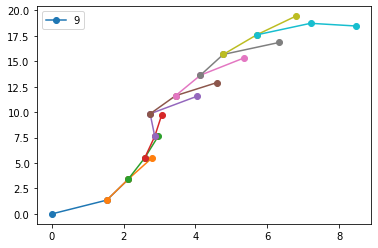

In [105]:
# still working on this part

Xfinal = np.zeros((Tf,3))

LengthHorizon = 3
eps = 0.5
y = np.zeros((3,LengthHorizon))

def fun(x,u):
    index = min(range(len(Sequence)), key=lambda i: abs(Sequence[i].x-x[0]))
    return x[1]-Sequence[index].y
lb = -0.1
ub = 0.1

ite = 0

while (abs(y[0,LengthHorizon-1]-xf[0])>eps or abs(y[1,LengthHorizon-1]-xf[1])>eps) and ite<15:
    print("step %s" % ite)
    if (ite+LengthHorizon<Tf):
        index = ite+LengthHorizon
    else:
        index = Tf-1

    #xgoal = [tps[index], 3*np.sin(tps[index]/3), (tps[index]-tps[index-1])/Tf]
    traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
    term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
     

    constraints = [(scopt.NonlinearConstraint, fun, lb, ub), opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi]) ]
    #constraints = []

    horizon = np.linspace(0, LengthHorizon, LengthHorizon, endpoint=True)
    result = opt.solve_ocp(vehicle, horizon, x0, traj_cost, constraints,terminal_cost=term_cost, initial_guess=u0)

    # Simulate the system dynamics (open loop)
    resp = ct.input_output_response(
        vehicle, horizon, result.inputs, x0,
        t_eval=np.linspace(0, LengthHorizon, LengthHorizon))
    t, y, u = resp.time, resp.outputs, resp.inputs
    
    x0 = y[:,1]

    Xfinal[ite,:] = y[:,1]
    plt.plot(y[0], y[1], 'o-')
    plt.legend("%s" %ite)
    ite += 1

for j in range(LengthHorizon):
    Xfinal[Tf-LengthHorizon+j,:] = y[:,len(y)-LengthHorizon+j]

plt.plot(xaxis, yaxis, 'g')
#plt.plot(Xfinal[0:ite+LengthHorizon,0],Xfinal[0:ite+LengthHorizon,1],'yo--',linewidth=5.0)
plt.show()

PID

In [118]:
#at last, where the added value of a MPC controller ? hmmm, difficult to see
# so let's go PID

#to put in the initialization file
# global parameters !!!
Kp = 0
Ki = 0
Kd = 0
base_speed = 100
p = 0
i = 0
d = 0


def follow_path(robot: model.Robot, path: Sequence[model.Point]) -> model.MotorSpeed:
    ### Access the robot's pose
    # robot.position.x
    # robot.position.y
    # robot.position.z
    PosX = robot.position.x
    PosY = robot.position.y
    PosT = robot.angle
    index = min(range(len(Sequence)), key=lambda i: abs(Sequence[i].x-PosX))

    devH, devB = index, index
    if index>=len(Sequence)-1:
        devH = len(Sequence)-1
    if index==0:
        devB = 0
    theta = np.arctan( (Sequence[devH].y-Sequence[devB].y) / (Sequence[devH].x-Sequence[devB].x) )

    error = (PosY-Sequence[index].y) + (PosT-theta)

    p = error
    i += p
    d = p - lp

    lp = p

    correction = int(Kp*p + Ki*i + Kd*d)

    rspeed = base_speed + correction
    lspeed = base_speed - correction

    #restricting speeds of motors between 255 and -255
    if (rspeed > 255):
        rspeed = 255
      
    if (lspeed > 255):
        lspeed = 255
      
    if (rspeed < -255):
        rspeed = -255
      
    if (lspeed < -255):
        lspeed = -255

    ### Return the command to send to the motors
    return model.MotorSpeed(left=100, right=100)
    # pass

AttributeError: 'NonlinearIOSystem' object has no attribute 'u'